In [2]:
pip install ucimlrepo

In [11]:
# Spam Classification with Neural Networks
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.feature_selection import SelectKBest, f_classif
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import io
from contextlib import redirect_stdout
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [12]:

# Fetch dataset
spambase = fetch_ucirepo(id=94)

# Extract data
X = spambase.data.features
y = spambase.data.targets

# Convert y to a 1D array for easier use
y_values = y.values.ravel()

# Print basic dataset information
print("==== DATASET INFORMATION ====")
print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of spam emails: {y_values.sum()}")
print(f"Number of non-spam emails: {len(y_values) - y_values.sum()}")
print(f"Spam ratio: {y_values.mean()*100:.2f}%")


==== DATASET INFORMATION ====
Dataset shape: (4601, 57)
Number of features: 57
Number of samples: 4601
Number of spam emails: 1813
Number of non-spam emails: 2788
Spam ratio: 39.40%


# =============== **EXPLORATORY DATA ANALYSIS**=====================



==== EXPLORATORY DATA ANALYSIS ====


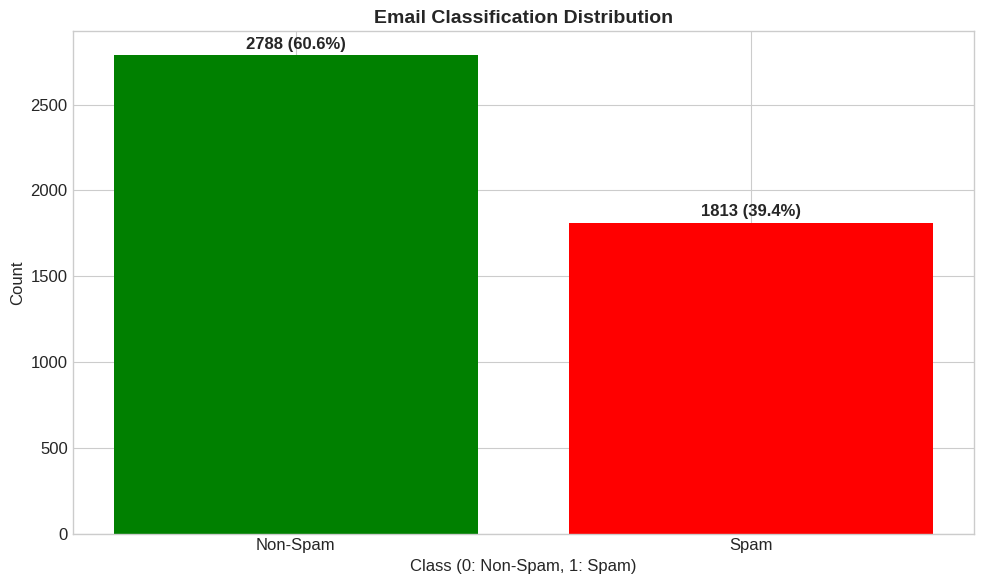

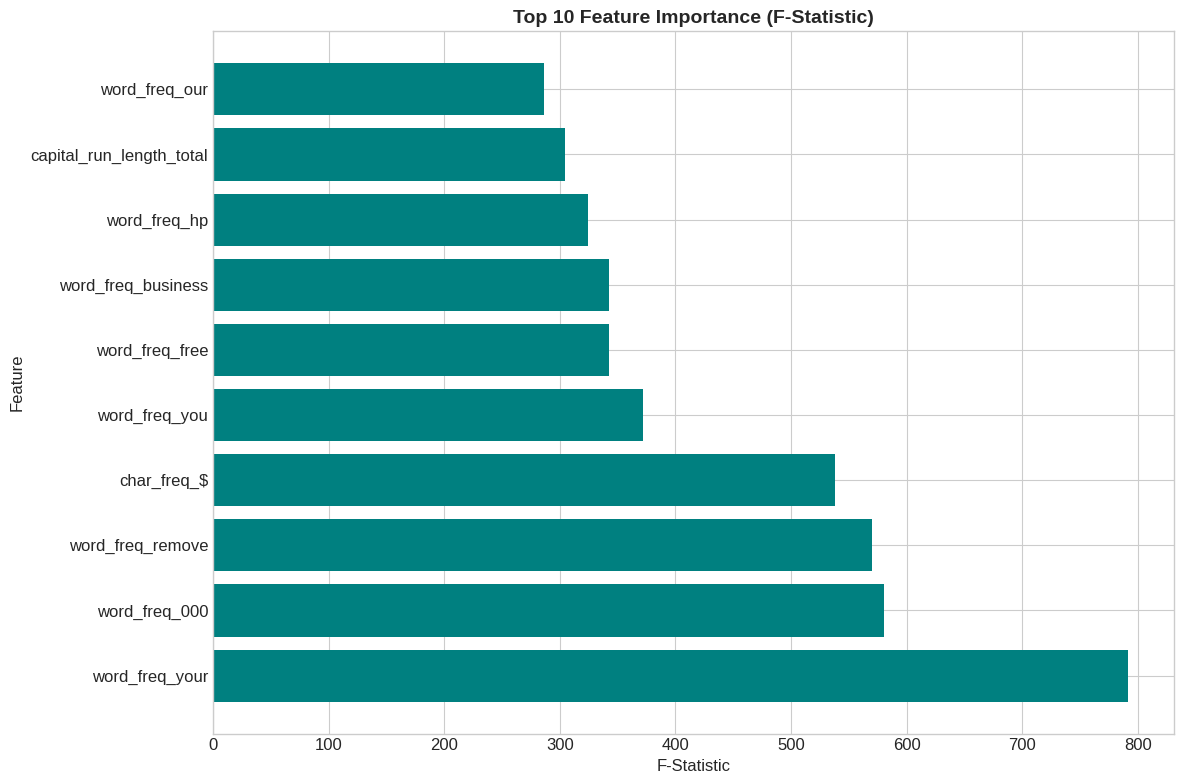

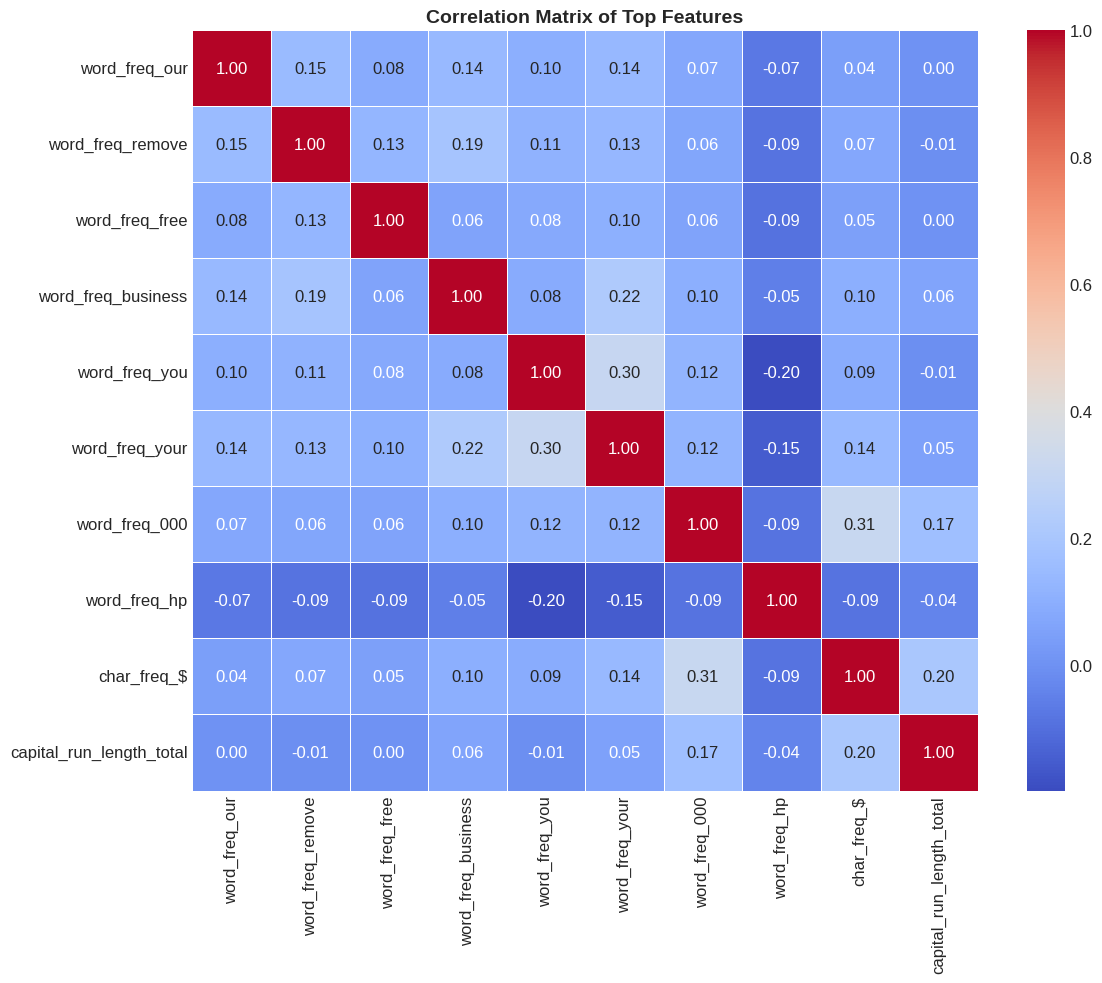

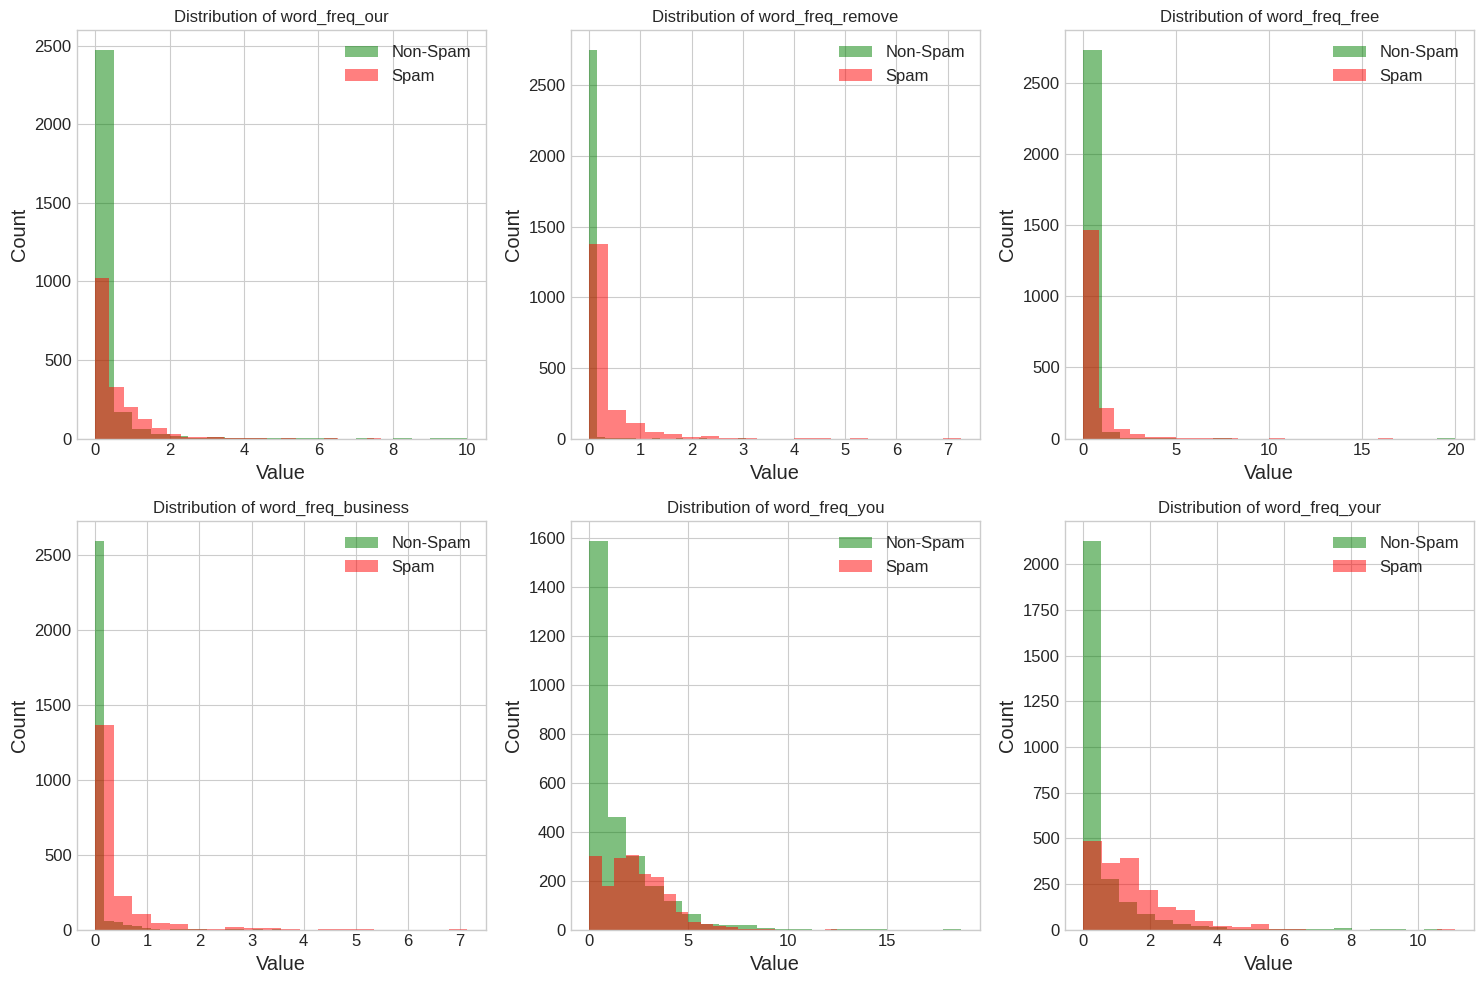

In [13]:

print("\n==== EXPLORATORY DATA ANALYSIS ====")

# 1. Target Distribution
plt.figure(figsize=(10, 6))
class_counts = pd.Series(y_values).value_counts()
plt.bar(class_counts.index, class_counts.values, color=['green', 'red'])
plt.title('Email Classification Distribution', fontweight='bold', fontsize=14)
plt.xlabel('Class (0: Non-Spam, 1: Spam)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Spam', 'Spam'])

# Add count labels
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 20, f"{count} ({count/len(y_values)*100:.1f}%)",
             ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Feature Importance Analysis
# Find top 10 discriminating features using SelectKBest
selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X, y_values)
top_feature_indices = selector.get_support(indices=True)
top_features = X.columns[top_feature_indices].tolist()

plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'F-Statistic': selector.scores_
}).sort_values('F-Statistic', ascending=False)
top_importance = feature_importance.head(10)
plt.barh(top_importance['Feature'], top_importance['F-Statistic'], color='teal')
plt.title('Top 10 Feature Importance (F-Statistic)', fontsize=14, fontweight='bold')
plt.xlabel('F-Statistic', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# 3. Correlation Matrix of Top Features
plt.figure(figsize=(12, 10))
corr_matrix = X[top_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Top Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Feature distributions by class
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features[:6]):
    plt.subplot(2, 3, i+1)
    # Plot separate histograms for each class
    plt.hist(X[feature][y_values == 0], bins=20, alpha=0.5, color='green', label='Non-Spam')
    plt.hist(X[feature][y_values == 1], bins=20, alpha=0.5, color='red', label='Spam')
    plt.title(f'Distribution of {feature}', fontsize=12)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.legend()
plt.tight_layout()
plt.show()


# ===================== **DATA PREPARATION** =====================


In [14]:

print("\n==== DATA PREPARATION ====")

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_values, test_size=0.2, random_state=42, stratify=y_values
)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")



==== DATA PREPARATION ====
Training set shape: (3680, 57)
Test set shape: (921, 57)


# ===================== **NEURAL NETWORK MODEL** =====================


In [15]:

class SpamClassifierANN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rates, activation=nn.ReLU, use_batch_norm=False):
        super(SpamClassifierANN, self).__init__()

        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.activation = activation()

        # Input layer
        prev_size = input_size

        # Hidden layers
        for i, (size, dropout) in enumerate(zip(hidden_sizes, dropout_rates)):
            self.layers.append(nn.Linear(prev_size, size))
            if use_batch_norm:
                self.batch_norms.append(nn.BatchNorm1d(size))
            self.dropouts.append(nn.Dropout(dropout))
            prev_size = size

        # Output layer
        self.output_layer = nn.Linear(prev_size, 1)

        self.use_batch_norm = use_batch_norm

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.use_batch_norm:
                x = self.batch_norms[i](x)
            x = self.activation(x)
            x = self.dropouts[i](x)

        x = self.output_layer(x)
        return x

    def visualize_architecture(self):
        """Generate a text visualization of the model architecture"""
        with io.StringIO() as buf, redirect_stdout(buf):
            print("Spam Classifier ANN Architecture:")
            print("=====================================")
            print(f"Input Size: {self.layers[0].in_features}")

            for i, layer in enumerate(self.layers):
                print(f"Layer {i+1}: Linear({layer.in_features}, {layer.out_features})")
                if self.use_batch_norm:
                    print(f"         BatchNorm1d({layer.out_features})")
                print(f"         {self.activation.__class__.__name__}")
                print(f"         Dropout(p={self.dropouts[i].p})")

            print(f"Output Layer: Linear({self.output_layer.in_features}, 1)")
            print(f"               Sigmoid (applied after forward pass)")
            print("=====================================")

            return buf.getvalue()

# Function to evaluate model performance
def evaluate_model(model, X_train_tensor, y_train, X_test_tensor, y_test):
    model.eval()
    with torch.no_grad():
        # Training predictions for learning curve
        train_outputs = model(X_train_tensor)
        train_probs = torch.sigmoid(train_outputs).numpy().flatten()
        train_preds = (train_probs >= 0.5).astype(int)

        # Test predictions
        test_outputs = model(X_test_tensor)
        test_probs = torch.sigmoid(test_outputs).numpy().flatten()
        test_preds = (test_probs >= 0.5).astype(int)

        # Calculate metrics
        train_acc = accuracy_score(y_train, train_preds)
        test_acc = accuracy_score(y_test, test_preds)
        precision = precision_score(y_test, test_preds)
        recall = recall_score(y_test, test_preds)
        f1 = f1_score(y_test, test_preds)
        roc_auc = roc_auc_score(y_test, test_probs)

        # Confusion matrix
        cm = confusion_matrix(y_test, test_preds)

    return {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'train_probs': train_probs,
        'test_probs': test_probs,
        'train_preds': train_preds,
        'test_preds': test_preds,
        'confusion_matrix': cm
    }

# Function to train and evaluate a model with validation metrics tracking
def train_and_evaluate_model(model, model_name, criterion, optimizer,
                            train_loader, X_train_tensor, y_train, X_test_tensor, y_test,
                            scheduler=None, num_epochs=100, early_stopping=True):
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    best_loss = float('inf')
    patience = 10
    patience_counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss/len(train_loader)
        loss_history.append(epoch_loss)

        # Evaluate model periodically
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            metrics = evaluate_model(model, X_train_tensor, y_train, X_test_tensor, y_test)
            train_acc_history.append(metrics['train_accuracy'])
            test_acc_history.append(metrics['test_accuracy'])

        if scheduler:
            scheduler.step(epoch_loss)

        # Early stopping logic
        if early_stopping:
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    model.load_state_dict(best_model_state)
                    break

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Load best model if early stopping was used
    if early_stopping and best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    final_metrics = evaluate_model(model, X_train_tensor, y_train, X_test_tensor, y_test)

    print(f"\nModel Results ({model_name}):")
    print(f"Train Accuracy: {final_metrics['train_accuracy']:.4f}")
    print(f"Test Accuracy: {final_metrics['test_accuracy']:.4f}")
    print(f"Precision: {final_metrics['precision']:.4f}")
    print(f"Recall: {final_metrics['recall']:.4f}")
    print(f"F1 Score: {final_metrics['f1']:.4f}")
    print(f"ROC AUC: {final_metrics['roc_auc']:.4f}")

    return model, final_metrics, loss_history, train_acc_history, test_acc_history

# Function for enhanced visualization of model performance - SIMPLIFIED VERSION
def visualize_model_performance(model, model_name, metrics, loss_history,
                              train_acc_history, test_acc_history):

    # Create a 2x3 grid of plots
    plt.figure(figsize=(18, 12))

    # 1. Confusion Matrix
    plt.subplot(2, 3, 1)
    cm = metrics['confusion_matrix']
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks([0, 1], ["Non-Spam", "Spam"])
    plt.yticks([0, 1], ["Non-Spam", "Spam"])

    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=14, fontweight='bold')

    # 2. Learning Curves
    plt.subplot(2, 3, 2)
    plt.plot(loss_history)
    plt.title('Learning Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # 3. Accuracy History
    plt.subplot(2, 3, 3)
    epochs = np.linspace(0, len(loss_history), len(train_acc_history))
    plt.plot(epochs, train_acc_history, '-o', label='Train Accuracy')
    plt.plot(epochs, test_acc_history, '-o', label='Test Accuracy')
    plt.title('Accuracy over Training', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # 4. ROC Curve
    plt.subplot(2, 3, 4)
    fpr, tpr, _ = roc_curve(y_test, metrics['test_probs'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
    plt.title('ROC Curve', fontsize=14, fontweight='bold')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)

    # 5. Precision-Recall Curve
    plt.subplot(2, 3, 5)
    precision, recall, _ = precision_recall_curve(y_test, metrics['test_probs'])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (area = {pr_auc:.3f})')
    plt.fill_between(recall, precision, alpha=0.2, color='green')
    plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="upper right")
    plt.grid(True, linestyle='--', alpha=0.7)

    # 6. Prediction Distribution - Use separate histograms instead of hue
    plt.subplot(2, 3, 6)
    # Non-spam predictions
    plt.hist(metrics['test_probs'][y_test == 0], bins=20, alpha=0.5,
            color='green', label='Non-Spam')
    # Spam predictions
    plt.hist(metrics['test_probs'][y_test == 1], bins=20, alpha=0.5,
            color='red', label='Spam')
    plt.title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Probability of Spam Class', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend()

    plt.tight_layout()
    plt.suptitle(f'Performance Analysis: {model_name}', fontsize=16, fontweight='bold', y=1.02)
    plt.subplots_adjust(top=0.92)
    plt.show()

    # Performance metrics bar chart
    plt.figure(figsize=(10, 6))
    metrics_values = [
        metrics['train_accuracy'],
        metrics['test_accuracy'],
        metrics['precision'],
        metrics['recall'],
        metrics['f1'],
        metrics['roc_auc']
    ]
    metrics_names = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
    bars = plt.bar(metrics_names, metrics_values, color='teal')
    plt.title('Performance Metrics', fontsize=14, fontweight='bold')
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Display model architecture
    print("\nModel Architecture:")
    print(model.visualize_architecture())



# ========**DEFINE 3 ANN MODELS WITH DIFFERENT ARCHITECTURES**=========


In [16]:
# Define configurations for the three ANN models
configs = [
    {
        'name': 'Simple ANN',
        'hidden_sizes': [32, 16],
        'dropout_rates': [0.2, 0.2],
        'activation': nn.ReLU,
        'batch_norm': False,
        'epochs': 80
    },
    {
        'name': 'Medium ANN with Batch Norm',
        'hidden_sizes': [64, 32, 16],
        'dropout_rates': [0.3, 0.3, 0.2],
        'activation': nn.ReLU,
        'batch_norm': True,
        'epochs': 120
    },
    {
        'name': 'Deep ANN with Leaky ReLU',
        'hidden_sizes': [128, 64, 32, 16],
        'dropout_rates': [0.4, 0.3, 0.3, 0.2],
        'activation': nn.LeakyReLU,
        'batch_norm': True,
        'epochs': 150
    }
]


# ===================== **TRAIN MODELS** =====================



==== TRAINING NEURAL NETWORK MODELS ====

--- Training Simple ANN ---
Epoch [10/80], Loss: 0.1562
Epoch [20/80], Loss: 0.1336
Epoch [30/80], Loss: 0.1222
Epoch [40/80], Loss: 0.1153
Epoch [50/80], Loss: 0.1035
Epoch [60/80], Loss: 0.0948
Epoch [70/80], Loss: 0.0893
Epoch [80/80], Loss: 0.0853

Model Results (Simple ANN):
Train Accuracy: 0.9785
Test Accuracy: 0.9338
Precision: 0.9314
Recall: 0.8981
F1 Score: 0.9144
ROC AUC: 0.9778


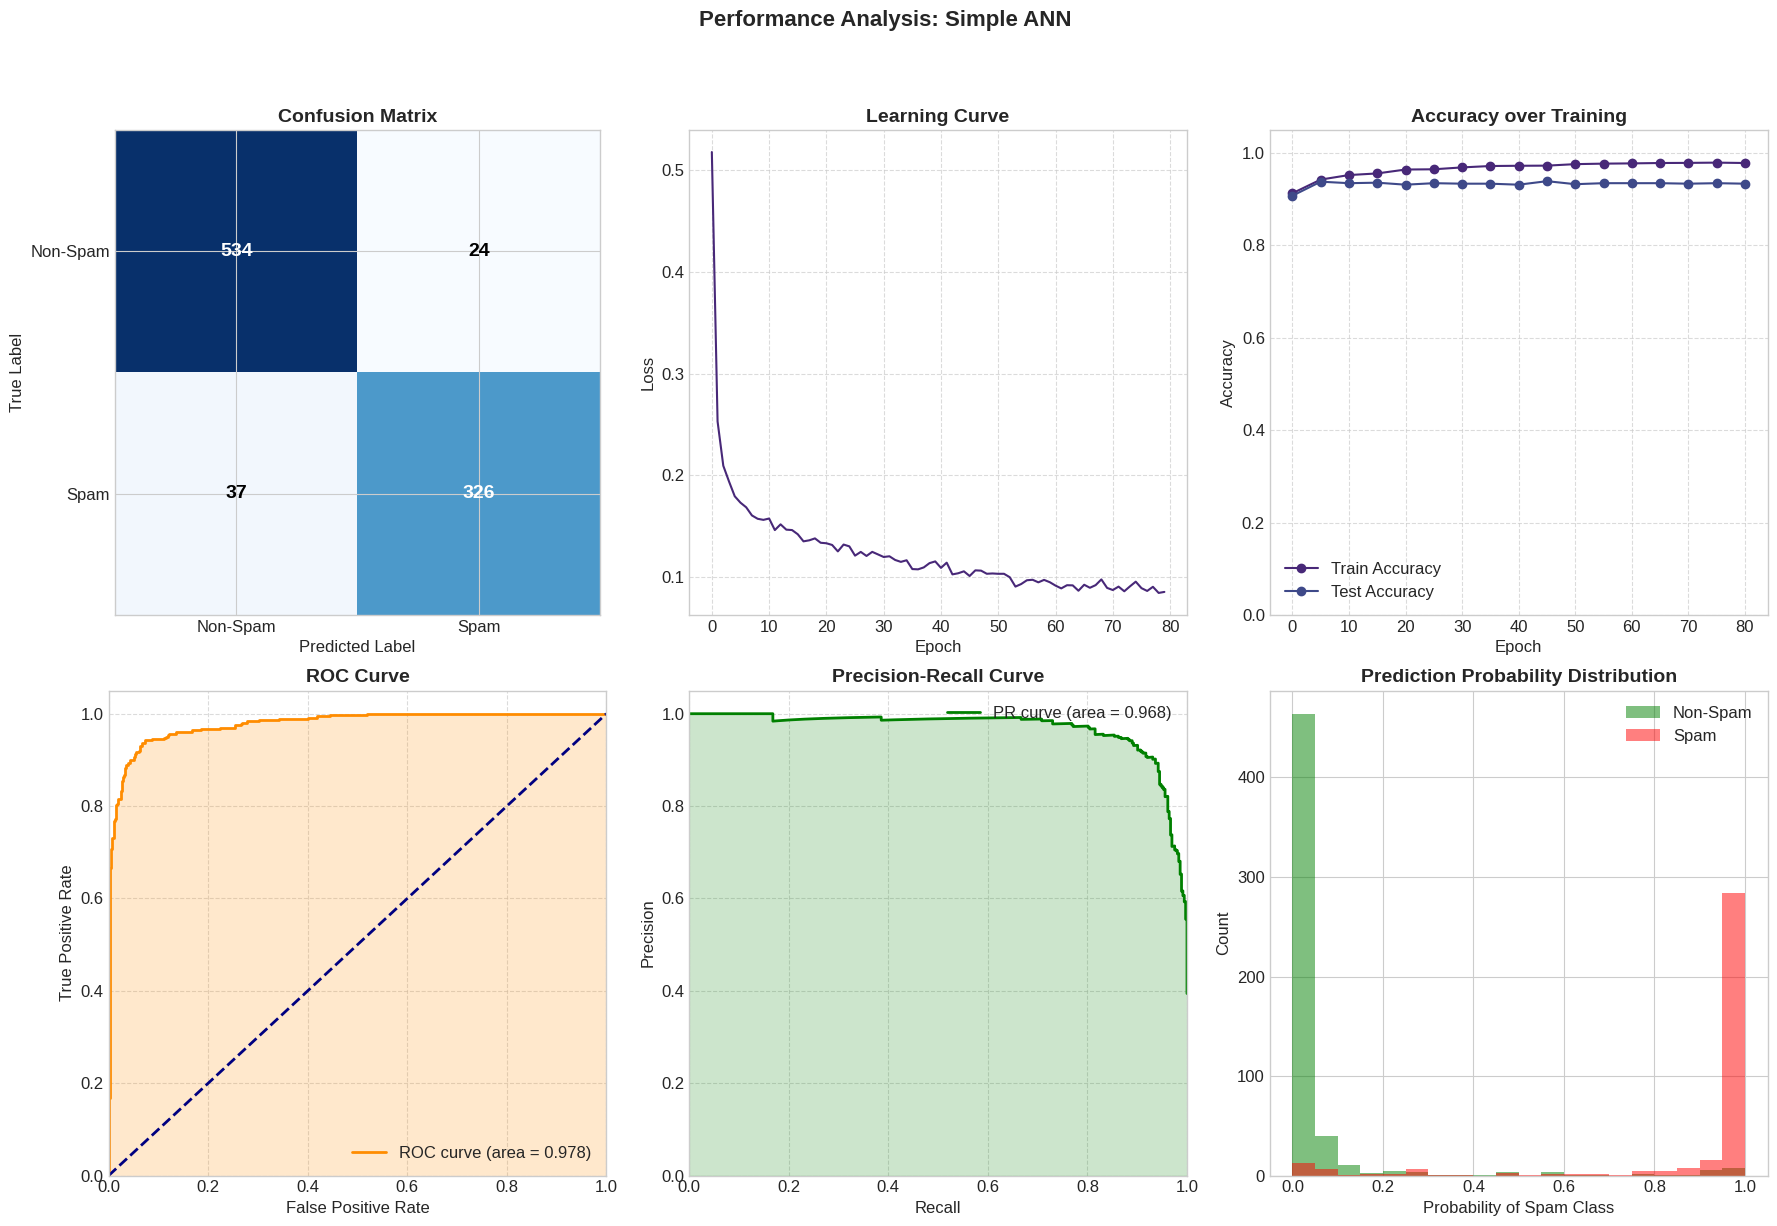

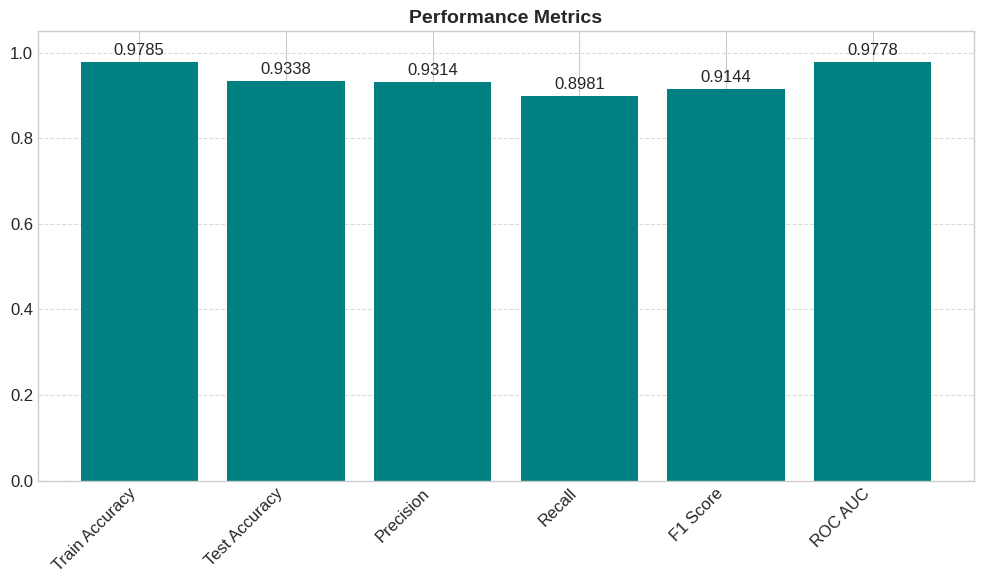


Model Architecture:
Spam Classifier ANN Architecture:
Input Size: 57
Layer 1: Linear(57, 32)
         ReLU
         Dropout(p=0.2)
Layer 2: Linear(32, 16)
         ReLU
         Dropout(p=0.2)
Output Layer: Linear(16, 1)
               Sigmoid (applied after forward pass)


--- Training Medium ANN with Batch Norm ---
Epoch [10/120], Loss: 0.2074
Epoch [20/120], Loss: 0.1773
Epoch [30/120], Loss: 0.1737
Epoch [40/120], Loss: 0.1691
Epoch [50/120], Loss: 0.1654
Epoch [60/120], Loss: 0.1608
Early stopping at epoch 65

Model Results (Medium ANN with Batch Norm):
Train Accuracy: 0.9679
Test Accuracy: 0.9305
Precision: 0.9188
Recall: 0.9036
F1 Score: 0.9111
ROC AUC: 0.9809


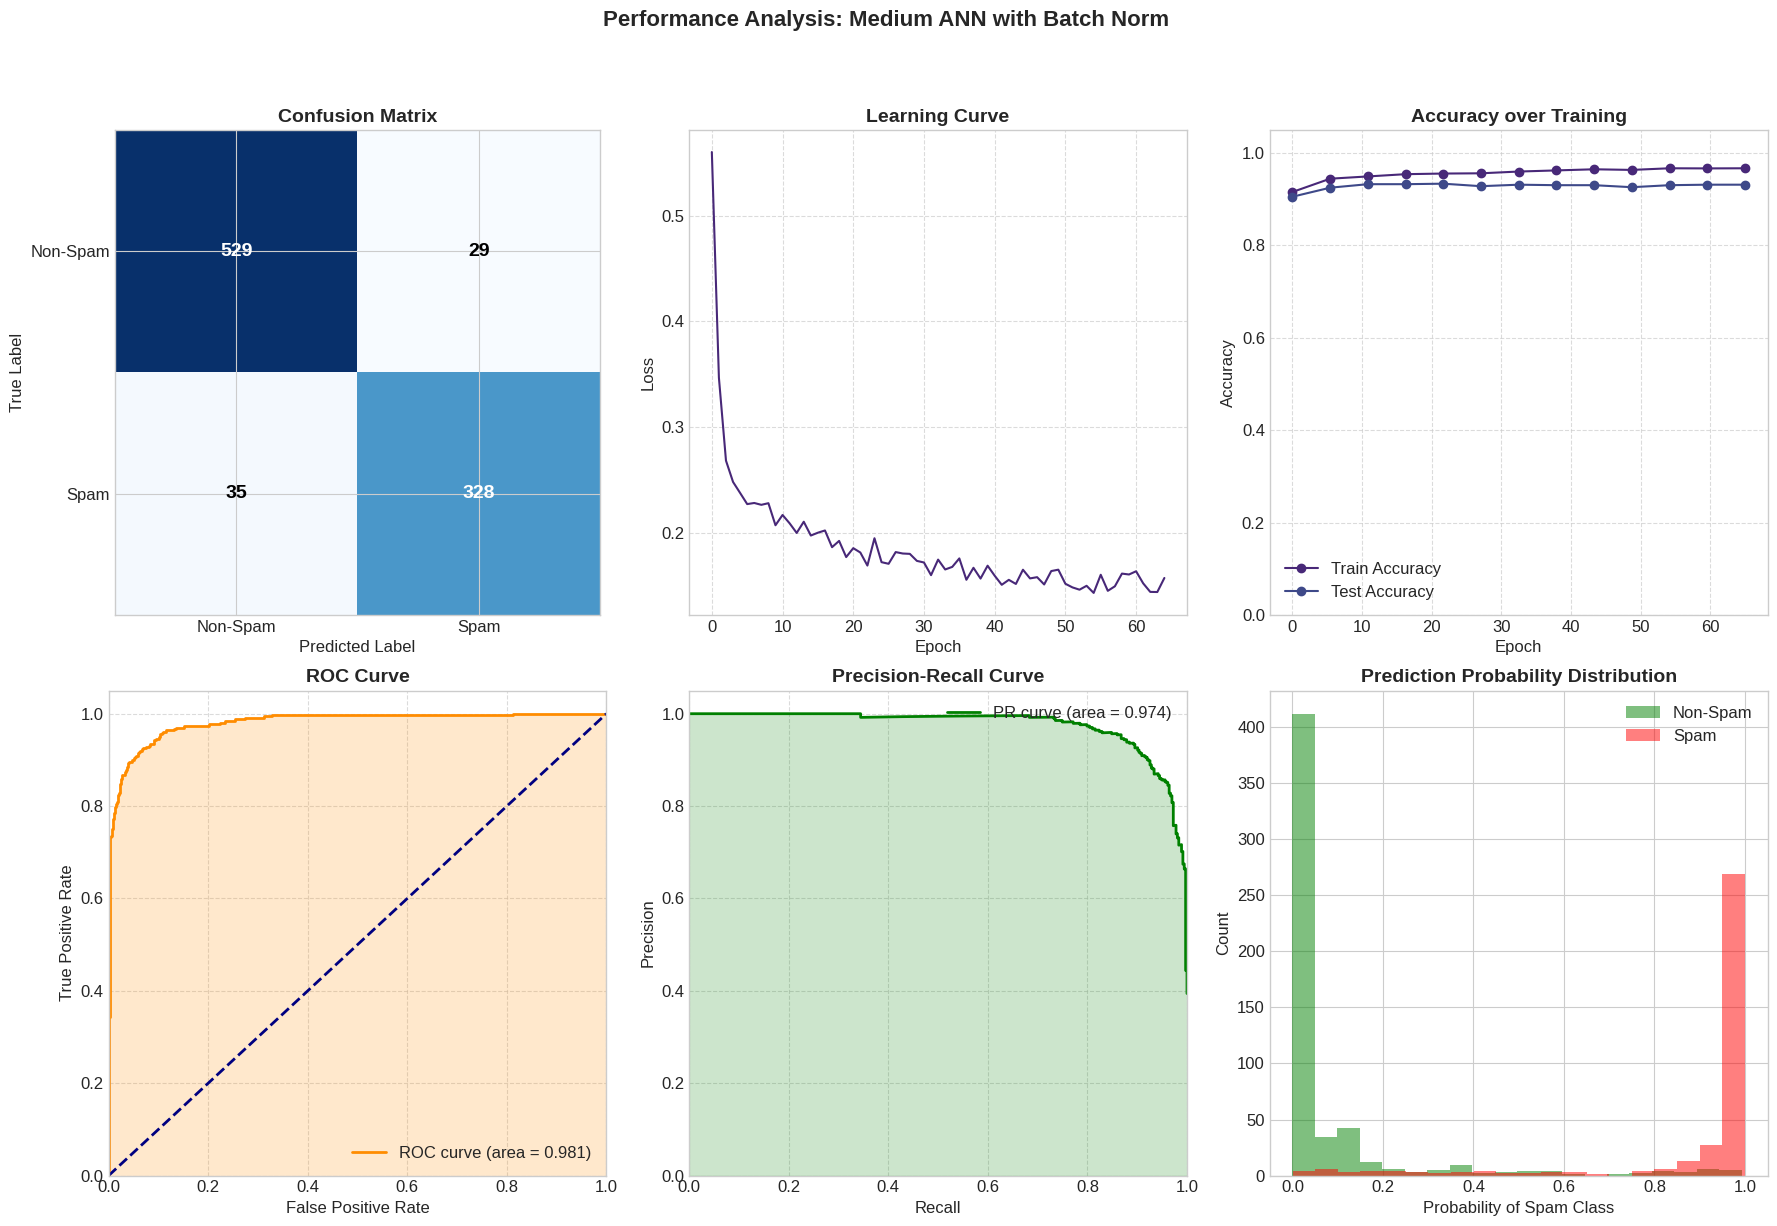

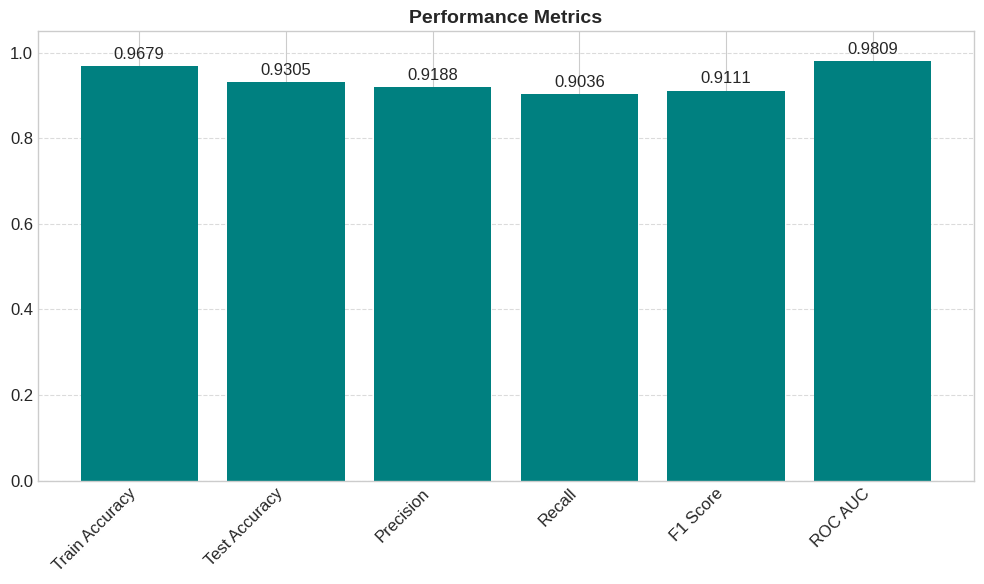


Model Architecture:
Spam Classifier ANN Architecture:
Input Size: 57
Layer 1: Linear(57, 64)
         BatchNorm1d(64)
         ReLU
         Dropout(p=0.3)
Layer 2: Linear(64, 32)
         BatchNorm1d(32)
         ReLU
         Dropout(p=0.3)
Layer 3: Linear(32, 16)
         BatchNorm1d(16)
         ReLU
         Dropout(p=0.2)
Output Layer: Linear(16, 1)
               Sigmoid (applied after forward pass)


--- Training Deep ANN with Leaky ReLU ---
Epoch [10/150], Loss: 0.2169
Epoch [20/150], Loss: 0.1818
Epoch [30/150], Loss: 0.1724
Epoch [40/150], Loss: 0.1565
Epoch [50/150], Loss: 0.1377
Epoch [60/150], Loss: 0.1497
Early stopping at epoch 61

Model Results (Deep ANN with Leaky ReLU):
Train Accuracy: 0.9715
Test Accuracy: 0.9305
Precision: 0.9188
Recall: 0.9036
F1 Score: 0.9111
ROC AUC: 0.9845


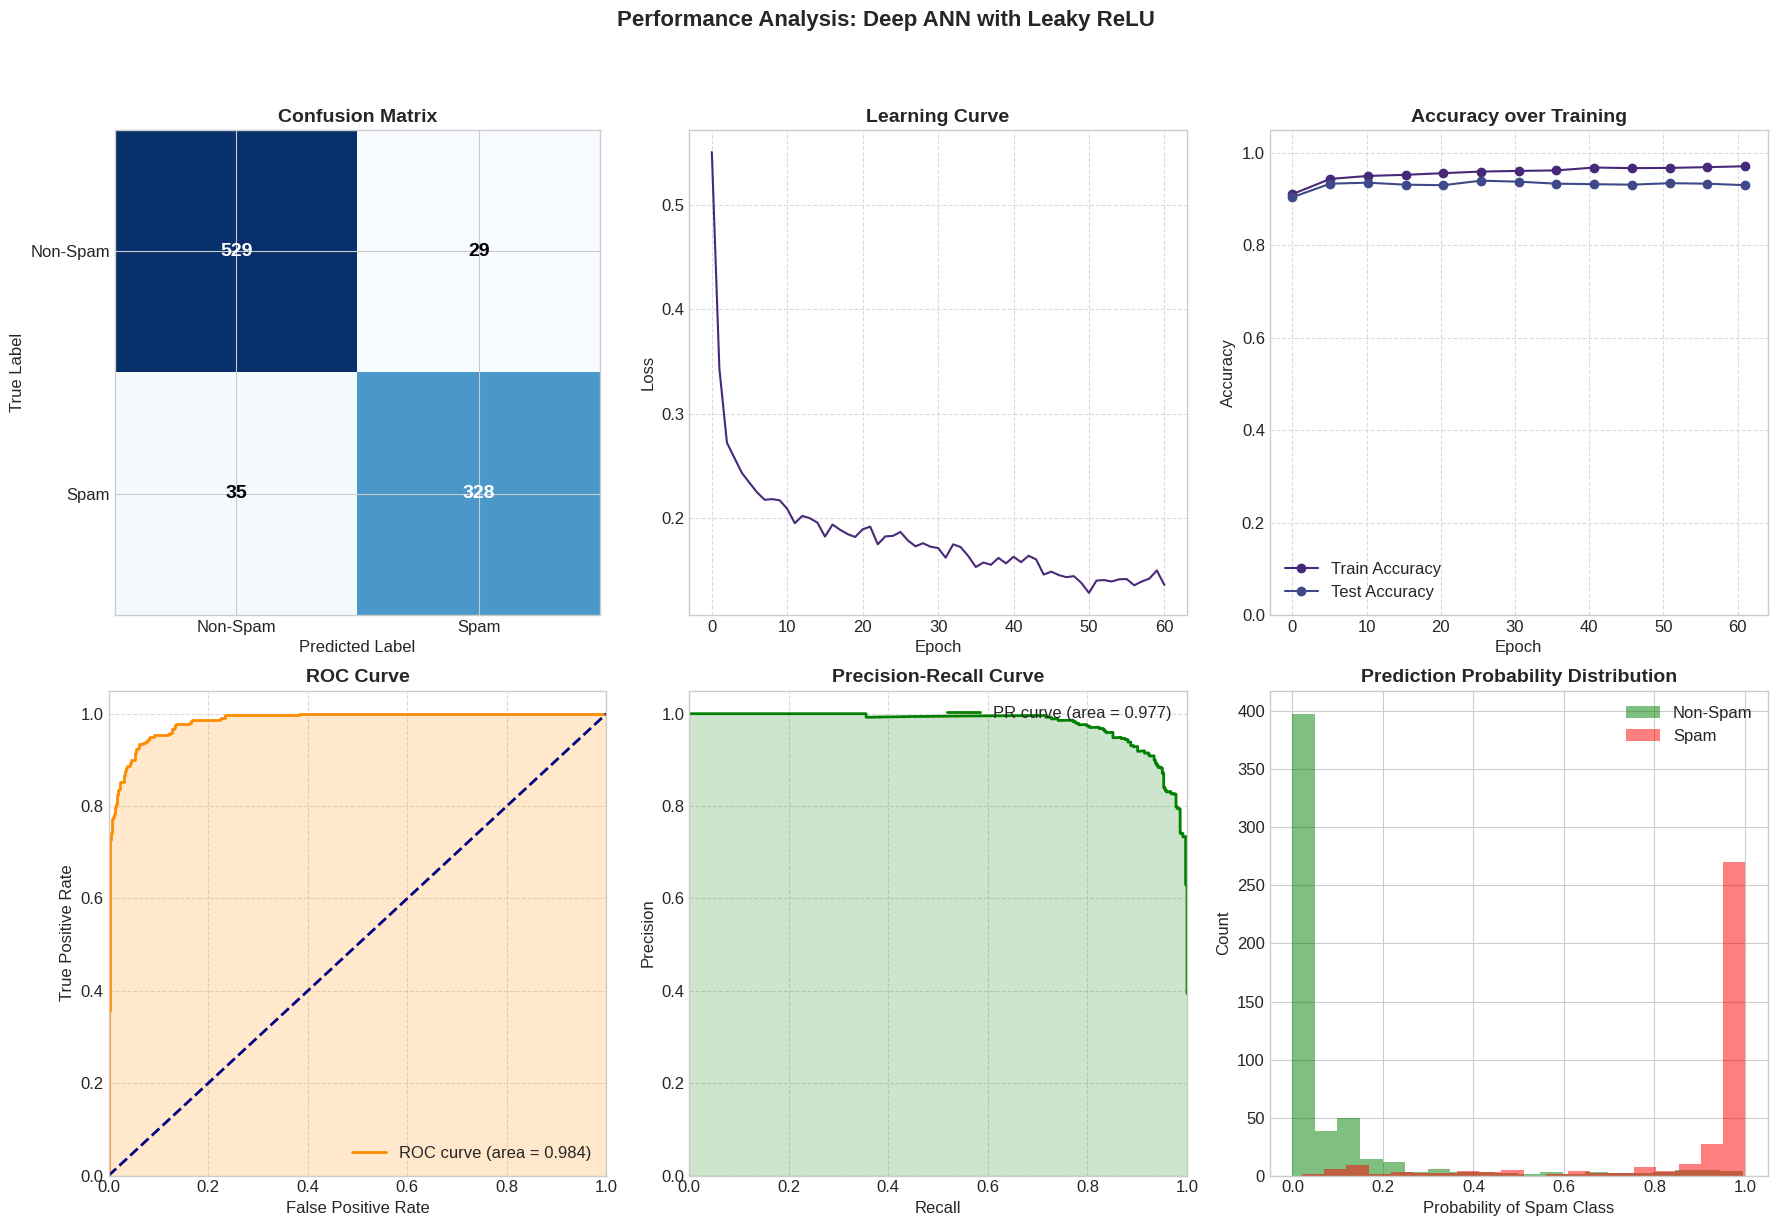

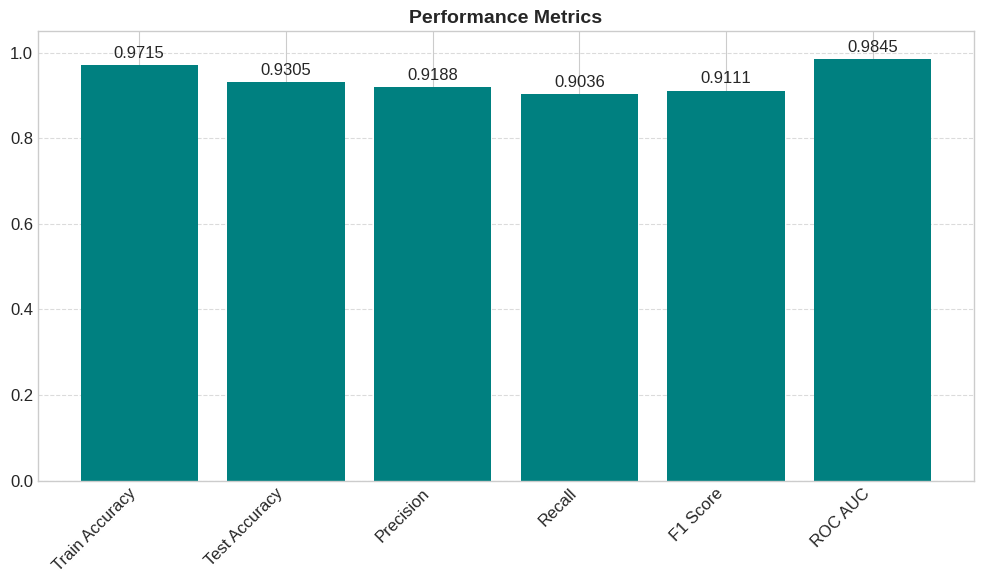


Model Architecture:
Spam Classifier ANN Architecture:
Input Size: 57
Layer 1: Linear(57, 128)
         BatchNorm1d(128)
         LeakyReLU
         Dropout(p=0.4)
Layer 2: Linear(128, 64)
         BatchNorm1d(64)
         LeakyReLU
         Dropout(p=0.3)
Layer 3: Linear(64, 32)
         BatchNorm1d(32)
         LeakyReLU
         Dropout(p=0.3)
Layer 4: Linear(32, 16)
         BatchNorm1d(16)
         LeakyReLU
         Dropout(p=0.2)
Output Layer: Linear(16, 1)
               Sigmoid (applied after forward pass)



In [17]:

print("\n==== TRAINING NEURAL NETWORK MODELS ====")

# Store all results
models = []
all_metrics = []
all_loss_histories = []
all_train_acc_histories = []
all_test_acc_histories = []

for config in configs:
    print(f"\n--- Training {config['name']} ---")

    # Initialize model
    model = SpamClassifierANN(
        input_size=X_train_scaled.shape[1],
        hidden_sizes=config['hidden_sizes'],
        dropout_rates=config['dropout_rates'],
        activation=config['activation'],
        use_batch_norm=config['batch_norm']
    )

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                   patience=5, verbose=True)

    # Train and evaluate
    model, metrics, loss_history, train_acc_history, test_acc_history = train_and_evaluate_model(
        model, config['name'], criterion, optimizer, train_loader,
        X_train_tensor, y_train, X_test_tensor, y_test,
        scheduler, config['epochs'])

    # Store results
    models.append(model)
    all_metrics.append(metrics)
    all_loss_histories.append(loss_history)
    all_train_acc_histories.append(train_acc_history)
    all_test_acc_histories.append(test_acc_history)

    # Visualize model performance
    visualize_model_performance(
        model, config['name'], metrics, loss_history,
        train_acc_history, test_acc_history
    )


# ===================== **MODELS COMPARISON** =====================



==== COMPARING ALL MODELS ====
                        Model  Train Accuracy  Test Accuracy  Precision  \
0                  Simple ANN        0.978533       0.933768   0.931429   
1  Medium ANN with Batch Norm        0.967935       0.930510   0.918768   
2    Deep ANN with Leaky ReLU        0.971467       0.930510   0.918768   

     Recall  F1 Score   ROC AUC  
0  0.898072  0.914446  0.977789  
1  0.903581  0.911111  0.980938  
2  0.903581  0.911111  0.984473  


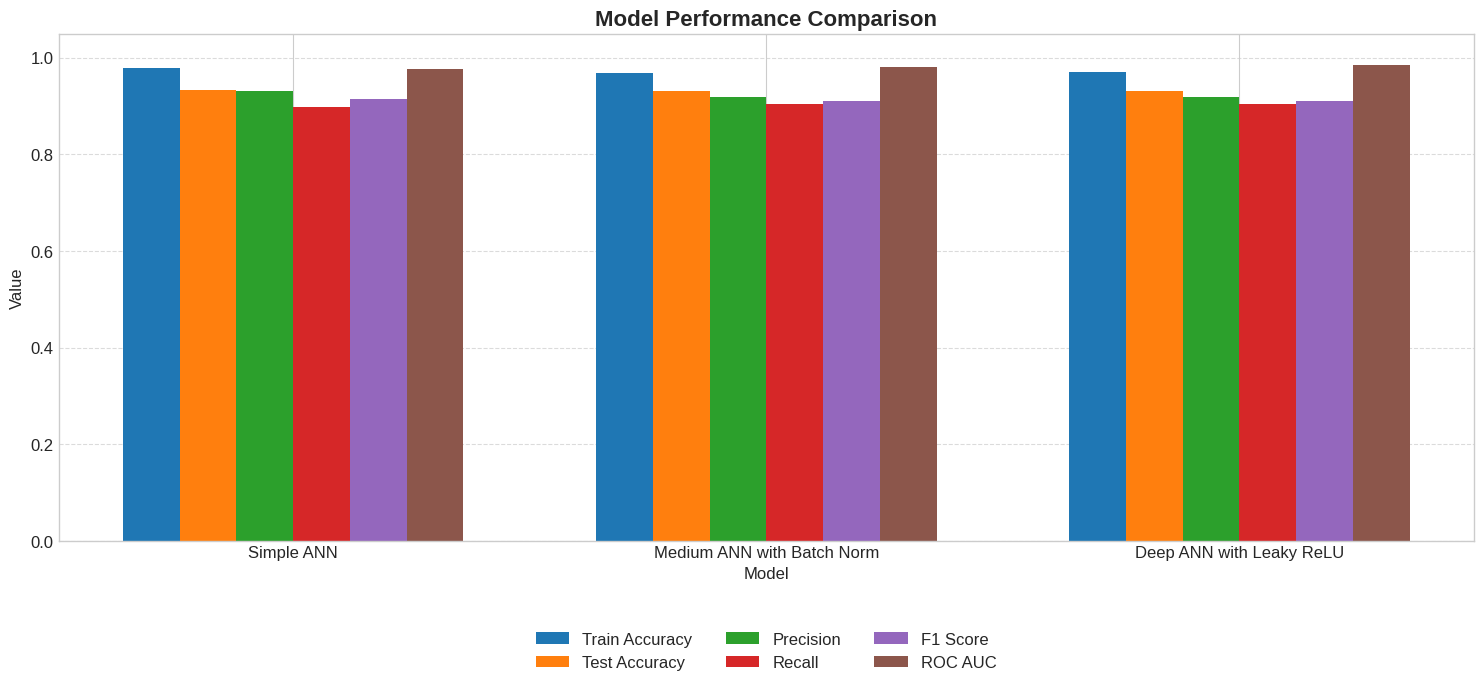

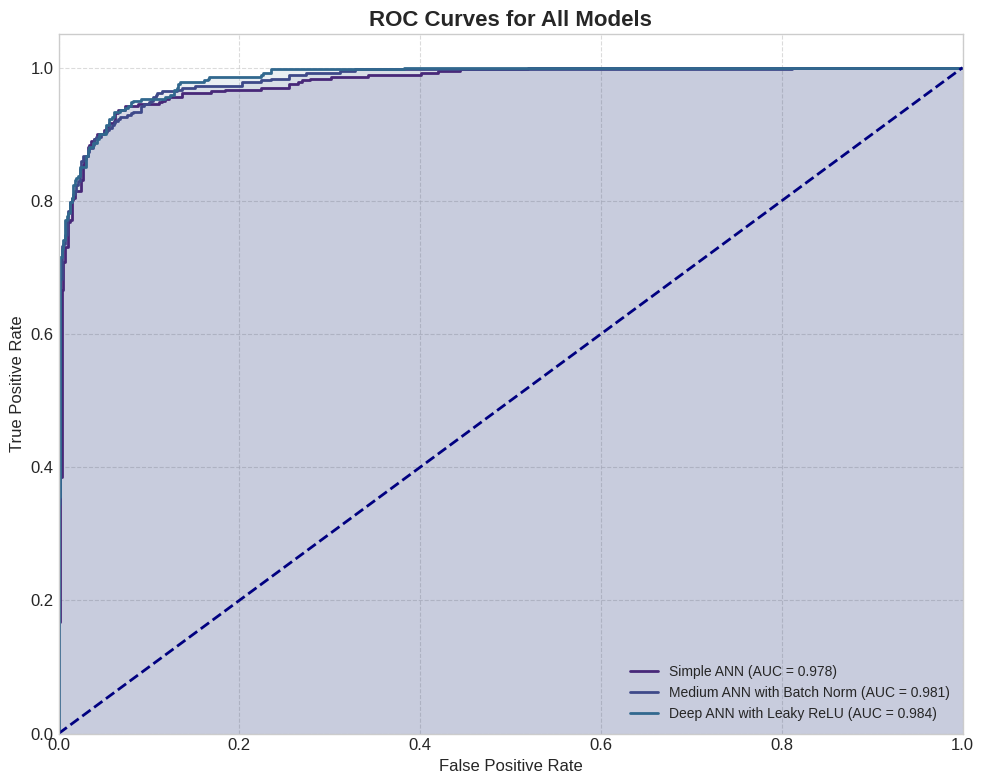

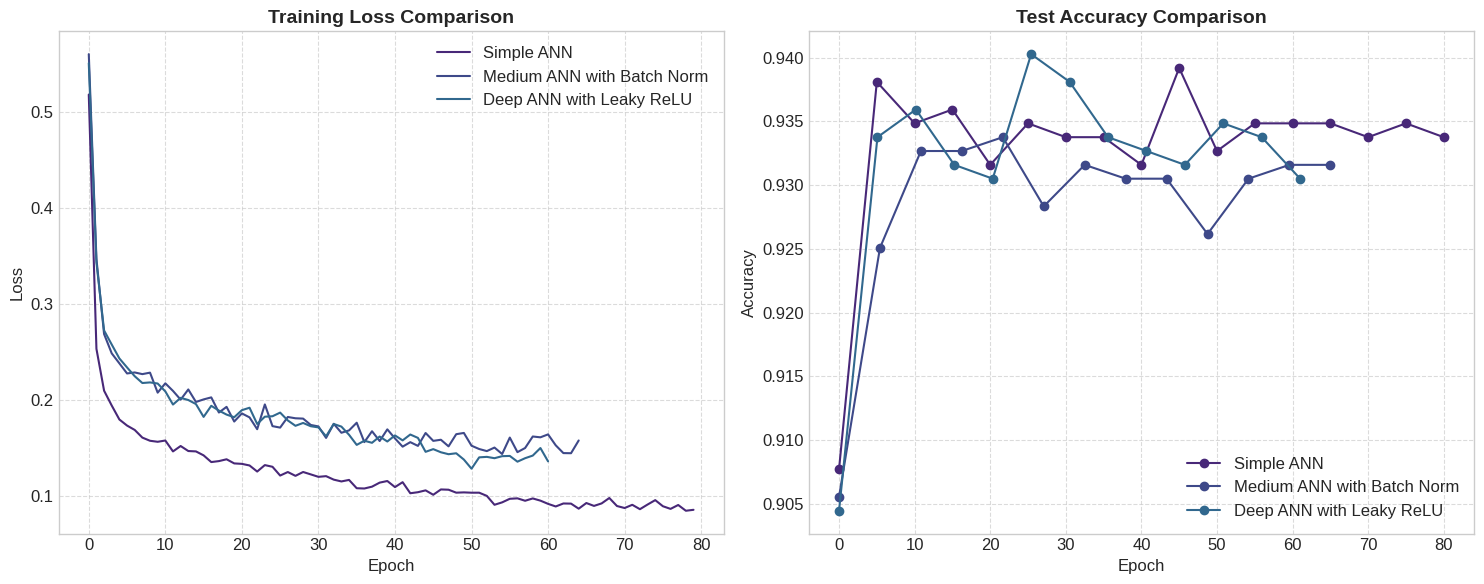


Spam Classification Neural Network Analysis Completed


In [18]:

print("\n==== COMPARING ALL MODELS ====")

# Create a DataFrame with all results
results = []
for i, config in enumerate(configs):
    results.append({
        'Model': config['name'],
        'Train Accuracy': all_metrics[i]['train_accuracy'],
        'Test Accuracy': all_metrics[i]['test_accuracy'],
        'Precision': all_metrics[i]['precision'],
        'Recall': all_metrics[i]['recall'],
        'F1 Score': all_metrics[i]['f1'],
        'ROC AUC': all_metrics[i]['roc_auc']
    })

results_df = pd.DataFrame(results)
print(results_df)

# Visualize model comparison - using simpler matplotlib
plt.figure(figsize=(15, 8))

# Prepare data for grouped bar chart
x = np.arange(len(configs))
width = 0.12
metrics = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Plot each metric as a group
for i, metric in enumerate(metrics):
    plt.bar(x + i*width - 0.3, results_df[metric], width, label=metric, color=colors[i])

plt.xlabel('Model', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xticks(x, results_df['Model'])
plt.ylim(0, 1.05)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

# Plot ROC curves for all models on the same plot
plt.figure(figsize=(10, 8))

for i, (config, metrics) in enumerate(zip(configs, all_metrics)):
    fpr, tpr, _ = roc_curve(y_test, metrics['test_probs'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,
             label=f'{config["name"]} (AUC = {roc_auc:.3f})')
    plt.fill_between(fpr, tpr, alpha=0.1)

# Add diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for All Models', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot learning curves
plt.figure(figsize=(15, 6))

# Loss curves
plt.subplot(1, 2, 1)
for i, config in enumerate(configs):
    plt.plot(all_loss_histories[i], label=config['name'])
plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Accuracy curves
plt.subplot(1, 2, 2)
for i, config in enumerate(configs):
    epochs = np.linspace(0, len(all_loss_histories[i]), len(all_test_acc_histories[i]))
    plt.plot(epochs, all_test_acc_histories[i], '-o', label=config['name'])
plt.title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\nSpam Classification Neural Network Analysis Completed")